<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 3 - Ensamblados y modelos avanzados </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Técnicas de ensamblado: *bagging*, *boosting* y *random forest*.
* Ventajas de técnicas de ensamblados
* Problemas desbalanceados
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y cierre competencia: 17 de Enero
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF393-II-2019]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Ensamblados para regresión  
[2.](#segundo) Detección de acoso en *Twitter*  

<a id="primero"></a>
## 1. Ensamblados para regresión
---
Las técnicas de ensamblados vistos en clases pueden ser aplicadas tanto a problemas de clasificación o regresión, teniendo la ventaja de utilizar múltiples modelos de aprendizaje para utilizar la ventaja de cada uno. En este actividad se trabajará con predecir la temperatura media de un día, dada cierta información del día anterior, como la humedad, velocidad del viento, presión atmosférica, fecha y temperatura. El modelo predictor derivado puede ser bastante útil para conocer el comportamiento del clima a lo largo del tiempo.

<img src="https://scijinks.gov/review/forecast-reliability/forecast-reliability2.jpg" title="Title text" width="70%"  />

Los datos de clima son recolectados en la ciudad Delhi de India por un período de 4 años (2013 a 2017), proporcionados en Kaggle a través del siguiente __[link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data)__, las particiones de entrenamiento y prueba están dadas. El registro de cada dato corresponde a un día, incrementando a través de las filas por cada día.

---
    
>  Cargue los datos en un dataframe de pandas, además agregue una columna indicando el valor a predecir, la temperatura media del día siguiente. *Como el último dato/registro no tiene un valor a predecir éste se elimina*.
```python
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row
```

> Debido a la poca información que se tiene a través de los 4 parámetros medidos, extraíga más información a través de los datos de fecha. Por ejemplo, el comportamiento a través de los meses y años varía, así como la información de la temporada del año podría ayudar a la predicción. Decida si puede incluir más información a partir de la fecha que tenga sentido con el problema.
```python
...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date
```

> Cree las matrices de entrenamiento, con los mil primeros registros, y de validación, con el resto. Para evitar el orden natural en que vienen los datos entrenados, realice un *shuffle* aleatorio.
```python
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only
```

> a) Describa el problema trabajado, la cantida de datos que se cuenta como las características a trabajar. Al ser datos temporales podría ayudar una ilustración gráfica de la secuencias trabajadas y su comportamiento ¿Es válido el uso de la información sólo del día anterior?.


> b) Entrene un solo Árbol de Regresión de múltiples niveles para resolver el problema. Defina un Árbol **no regularizado** (como el que no tiene límites en su profundidad) y otro Árbol **regularizado** (variando los hiper-parámetros que prefiera, por ejemplo, los más comunes como la profundidad, el número mínimo de datos para realizar *split* o el número mínimo de datos en cada hoja). Además comente sobre la ventaja de usar un árbol de decisión respecto a la escala de los datos ¿Porqué no es necesario escalar los datos?
```python
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
... #define your regularized tree model
``` 

> c) Para evaluar la calidad de predicción en este problema se utilizará la métrica *Root Mean Squared Error* (RMSE), indicando un error en la escala real de la temperatura. Como los datos de validación siguen con el orden temporal, visualice esa predicción a lo largo del tiempo. Comente sobre los resultados comparando la regularización *vs* el no regularizar.
```python
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()
```
    
> d) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **Bagging**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en b)*) ¿Qué debería suceder? ¿Se visualiza *overfitting*? Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier(base_estimator=Tree(...), n_estimators=..., n_jobs=-1)
```

> e) Entrene un ensamblado de árboles de múltiples niveles, mediante la técnica de **AdaBoost**, compare el Árbol **no regularizado** con el **regularizado** (*seteando los hiper-parámetros en base a lo experimentado anteriormente en d)* ¿Se visualiza *overfitting*? ¿Qué técnica utiliza la librería de sklearn, *re-muestrear* o *pesar* ejemplos? ¿Qué le parece más sensato?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro. Compare y analice con la técnica utilizada en d).
```python
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(base_estimator=Tree(...), n_estimators=...)
```

> f) Pruebe otra técnica de ensamblado dedicada a árboles de decisión, que combina el muestreo *boostrap* de *Bagging* con muestreo sobre las *features*: **Random Forest**, compare el Árbol **no regularizado** con el **regularizado** ¿Se visualiza *overfitting*?. Varíe la cantidad de árboles de decisión utilizados en el ensamblado (*n estimators*), realice un gráfico resumen del RMSE de entrenamiento y validación en función de este hiper-parámetro.
```python
from sklearn.ensemble import RandomForestClassifier
model_unr = RandomForestClassifier(n_estimators=..., n_jobs=-1)
... #define your regularized random forest model
```

> g) Verifique que el **OOB error** (*out of bag error*) de los ensambladores que utilizan la técnica *boostrap* puede ser una alternativa como métrica de generalización, compare con el error calculado sobre el conjunto de validación (o en su defecto *cross validation*).
```python
oob_error = model.oob_score_
val_error = model.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)
```

> h) Defina otra forma de combinar los valores que entregan los ensamblados al hacer predicciones y compare con lo que se hace actualmente, por ejemplo *Bagging* realiza el voto de la mayoría para clasificación y promedio para regresión, *AdaBoost* realiza una combinación ponderada de cada clasificador dependiendo de su *habilidad* (desempeño para clasificar el conjunto de entrenamiento). Se puede inspirar desde clásicos estadísticos, como entregar el primer cuartíl ($Q_1$) si al ensamblado le cuesta predecir valores bajos, o el segundo cuartil ($Q_2$) o mediana para ser robusto a predicciones atípicas de modelos.  
```python
def combine_predictions(predictions):
    return #define !
list_estimators = model.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))
```

> i) Si se cuenta con una gran cantidad de modelos en el ensamblado, por ejemplo $T>100$, se puede crear un intervalo de confianza de la predicción a través de todos estos valores, asumiendo una distribución Normal centrada en la media muestral de las predicciones, con desviación estándar muestral en las predicciones. El intervalo de confianza entrega más información que un único valor puntual de predicción. Visualice un intervalo de confianza al 95% de probabilidad en la predicción a lo largo de la serie de tiempo de validación, comente. Al asumir una distribución Normal, también puede explorar el tomar como predicción del ensamblado el muestreo sobre la distribución Normal creada entorno a los datos muestrales.
```python
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(8,5))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()
```
    
>  j) Evalúe y visualice la predicción del mejor modelo encontrado para resolver este problema, en el conjunto de pruebas. Además, compare y analice las distintas maneras con las que se resolvió el problema, incluya las decisiones que conlleva y los resultados que reflejan.
```python
df = pd.read_csv("DailyDelhiClimateTest.csv")
```

<a id="segundo"></a>
## 2. Detección de acoso en *Twitter*
En las redes sociales muchas veces se encuentra con un cierto comportamiento indeseable para los usuarios, tal como racismo, misógeno, grupos de odio o *trolls*. El poder detectar de manera automática ciertos patrones en el comportamiento para tomar una acción debe ser crucial para reducir el tiempo y esfuerzo humano. En esta actividad se trabajará sobre *tweets* la red social de *twitter* para detectar comportamiento *online* de acoso (*harassment*), que por lo general, incluye *flaming* como lenguaje abusivo o insultos, *doxing* como mostrar la información personal de una mujer, por ejemplo el domicilio o número de teléfono, la suplantación o la vergüenza pública por destruir la reputación de las personas.

<img src="https://kidshelpline.com.au/sites/default/files/bdl_image/header-T-OH.png" title="Title text" width="45%"  />

En algunos problemas como este, el comportamiento a detectar puede ser asociado a una anomalía (*outlier*) del comportamiento normal de los usuarios en las redes sociales. Esto es una de las causas de la dificultad del problema, puesto que es **altamente desbalanceado**, donde aproximadamente un 10% de los *tweets* corresponden a acoso (*harassment*).

Los datos trabajados corresponderan a *tweets* etiquetados como *harassment* (con valor 1) o no (con valor 0) -- la tarea a detectar--. Además si desea utilizar, se incluye la información del tipo de *harassment* en el conjunto de entrenamiento como atributos extras. El conjunto de pruebas solo contiene los *tweets* a ser etiquetados.


### Importante
* Esta pregunta será evaluada **sólo** por los resultados (*submission*) obtenidos en el desafío presentado en __[Kaggle](https://www.kaggle.com/c/t1-ml/)__ a través del siguiente __[link](https://www.kaggle.com/t/91f8c0c746f945cfa510b88469df4d67)__. Las notas serán entregadas a través de la siguiente fórmula:  
$$ Nota(i) = 100\cdot max\left(0.55; s^{(1-i)} \right), \ \ con \ \ i \in \{1,\ \ldots, N\}$$
Con la escala de decaimiento es $ s = 1.05$.

* La métrica de evaluación será el *f1 score* [[3]](#refs) sobre la clase positiva (*harassment*), así evaluar la calidad del modelo sobre la clase minoritaria, lo cual también debiera reflejar el desempeño de la clase negativa (al ser el complemento).
```python
from  sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='binary')
```

* El archivo de *submission* debe contener una columna de *id* asociado a cada conjunto de pruebas, iniciando en 1, se puede generar de la siguiente manera:
```python
df_aux = pd.DataFrame()
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("test_estimation.csv", index=False)
```

* Si no realiza *submission* a Kaggle su nota en esta sección será de 0

In [1]:
labels_name = {0:'NotH',1:"IndirectH",2:"PhysicalH",3:"SexualH"}
labels_code = {'NotH':0,"IndirectH":1,"PhysicalH":2,"SexualH":3}

df_set = pd.concat([df_train,df_val], ignore_index=True)
df_set["NotH"] = 1- df_set["harassment"]
df_set.columns = ["id", "tweet", "NotH","IndirectH","PhysicalH","SexualH"]
df_set["id"] = df_set["id"]+df_test.shape[0]+1
df_set = df_set.sample( frac=1, replace=False)
df_set["class"] = df_set.iloc[:,2:].idxmax(axis=1)
df_set["class"] = df_set["class"].apply(lambda x: labels_code[x])
df_set.drop(["NotH","IndirectH","PhysicalH","SexualH"], axis=1, inplace=True)
df_set


df_test["id"] = np.arange(1,1+ df_test.shape[0])
col = df_test.pop("id")
df_test.insert(0, col.name, col)
df_test["NotH"] = 1- df_test["harassment"]
df_test["class"] = df_test.iloc[:,2:].idxmax(axis=1)
df_test["class"] = df_test["class"].apply(lambda x: labels_code[x])
df_test.drop(["NotH","IndirectH","PhysicalH","SexualH"], axis=1, inplace=True)
df_test

df_set.to_csv("Train_data.csv", index=False)
df_test[["id","tweet"]].to_csv("Test_input.csv", index=False)
df_test[["id","class"]].to_csv("Test_label.csv", index=False)

In [259]:
import pandas as pd
import numpy as np
df_train = pd.read_csv("./SIMAH-C/Train_data_compeition.csv")
df_val = pd.read_csv("./SIMAH-C/Validation_data_competition.csv")
df_test = pd.read_csv("./SIMAH-C/testdata_gold_labels.csv")
df_test.drop([212, 1611], axis=0, inplace=True)

In [260]:
df_set = pd.concat([df_train,df_val], ignore_index=True)
df_set.rename({"Unnamed: 0":"id"}, inplace=True, axis=1)
df_set["id"] = df_set["id"]+df_test.shape[0]+1
df_set["NotH"] = 1- df_set["harassment"]
df_set = df_set.sample( frac=1, replace=False)

df_test["NotH"] = 1- df_test["harassment"]
df_set

,id,tweet_content,harassment,IndirectH,PhysicalH,SexualH,NotH
2441,4563,the fact this slut Jordan text me at 7 41 talm...,1,0,0,1,0
6072,8194,markhoppus you know I saw a girl fuck a rock ...,1,0,0,1,0
4249,6371,Extracting gravy dude n t co x2gQIdG5lh cumsh...,1,0,0,1,0
3240,5362,ava was such a badass bitch why did not more p...,1,0,0,1,0
7443,9565,also released this video of photos voyager too...,0,0,0,0,1
4672,6794,Yeah sexting older games until x89 teach doug...,0,0,0,0,1
2215,4337,ava There s likely hundreds of stories like t...,0,0,0,0,1
839,2961,pornaddicts18 GoddessesPorn Loveporngirlz18 p...,1,0,0,1,0
4499,6621,Wonder if there is significance to having Ava ...,0,0,0,0,1
3737,5859,find6xyz ashlyeroberts flashing boobs webcam ...,1,0,0,1,0


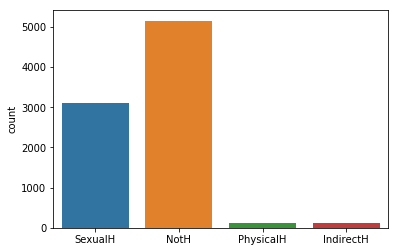

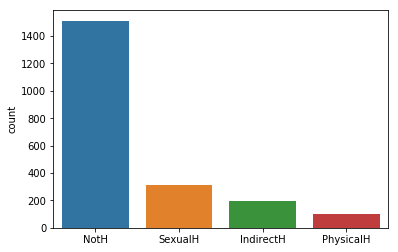

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(df_set[["IndirectH","PhysicalH","SexualH","NotH"]].idxmax(axis=1))
plt.show()

sns.countplot(df_test[["IndirectH","PhysicalH","SexualH","NotH"]].idxmax(axis=1))
plt.show()

In [262]:
mask_SH = (df_set["SexualH"]==1).values #mask
samp_idx_SH = df_set[mask_SH].sample(frac=0.1, replace=False).index
idx_notH = df_set[~mask_SH].index
wanted_indices = list(samp_idx_SH) + list(idx_notH)
desired_indices = [i for i in list(df_set.index) if i in wanted_indices]
new_df_set = df_set.loc[desired_indices]

print(new_df_set[["IndirectH","PhysicalH","SexualH","NotH"]].idxmax(axis=1).value_counts(normalize=True))


#now on test..
mask_SH = (df_test["SexualH"]==1).values #mask
samp_idx_SH = df_test[mask_SH].sample(frac=0.3, replace=False).index
mask_IH = (df_test["IndirectH"]==1).values #mask
samp_idx_IH = df_test[mask_IH].sample(frac=0.4, replace=False).index

idx_notH = df_test[~mask_SH & ~mask_IH].index
wanted_indices = list(idx_notH) + list(samp_idx_SH)  + list(samp_idx_IH) 
desired_indices = [i for i in list(df_test.index) if i in wanted_indices]
new_df_test = df_test.loc[desired_indices]

print(new_df_test[["IndirectH","PhysicalH","SexualH","NotH"]].idxmax(axis=1).value_counts(normalize=True))

new_df_test.head()

NotH         0.903735
SexualH      0.054533
IndirectH    0.022094
PhysicalH    0.019639
dtype: float64
NotH         0.847059
PhysicalH    0.056022
SexualH      0.052661
IndirectH    0.044258
dtype: float64


,tweet_content,harassment,IndirectH,PhysicalH,SexualH,NotH
0,is it wrong what about mezcal,0,0,0,0,1
1,is mkr on texts the sound you make with incaka...,0,0,0,0,1
2,is on now go girl bre,0,0,0,0,1
3,is only beaten by on anzac day eve k share which,0,0,0,0,1
4,is that a bowl cut on that chick,0,0,0,0,1


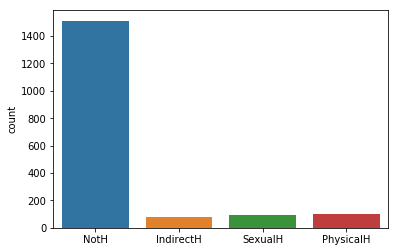

In [263]:
sns.countplot(new_df_test[["IndirectH","PhysicalH","SexualH","NotH"]].idxmax(axis=1))
plt.show()

0    5154
1     549
Name: harassment, dtype: int64


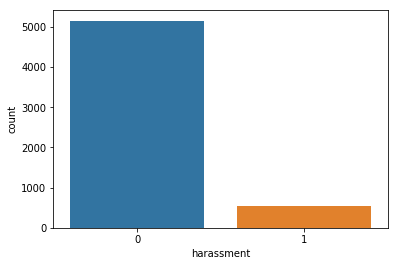

0    1512
1     273
Name: harassment, dtype: int64


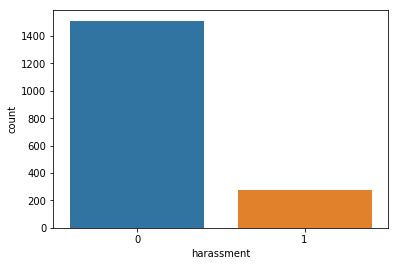

In [285]:
print(new_df_set["harassment"].value_counts(normalize=False))
sns.countplot(new_df_set["harassment"])
plt.show()

#print(new_df_test["harassment"].value_counts(normalize=True))
print(new_df_test["harassment"].value_counts())

sns.countplot(new_df_test["harassment"])
plt.show()

In [265]:
new_df_set.drop("NotH", axis=1, inplace=True)
new_df_test.drop("NotH", axis=1, inplace=True)

new_df_test["id"] = np.arange(1,1+ new_df_test.shape[0])
col = new_df_test.pop("id")
new_df_test.insert(0, col.name, col)

new_df_set.to_csv("Train_data.csv", index=False)
new_df_test[["id","tweet_content"]].to_csv("Test_input.csv", index=False)
new_df_test[["id","harassment"]].to_csv("Test_label.csv", index=False)

In [277]:
y_test = new_df_test["harassment"].values
y_test

array([0, 0, 0, ..., 0, 1, 1])

In [153]:
y_test = np.argmax(y_test,axis=-1)
y_test

array([0, 0, 0, ..., 2, 1, 2])

In [268]:
X = np.random.rand(y_test.shape[0],5)
X.shape

(2121, 5)

In [269]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
#model = LogisticRegression()
#model = DecisionTreeClassifier()
#model = BernoulliNB()
model = MLPClassifier()

model.fit(X,y_test)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [167]:
model.predict(X)

array([0, 0, 0, ..., 0, 0, 0])

In [270]:
y_pred = model.predict(X)

from  sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='binary')

/home/fmena/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [278]:
## predict only notH
y_pred = np.ones(y_test.shape[0])*0

from  sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='binary')

/home/fmena/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [279]:
df_aux = pd.DataFrame() #pd.DataFrame(np.concatenate([ids, y_pred], axis=-1), columns=["id","???"])
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("only_NotH.csv", index=False)

In [281]:
## predict only SexualH
y_pred = np.ones(y_test.shape[0])*1

from  sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='binary')

0.26530612244897961

In [282]:
df_aux = pd.DataFrame() #pd.DataFrame(np.concatenate([ids, y_pred], axis=-1), columns=["id","???"])
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("only_H.csv", index=False)

In [283]:
y_pred = np.random.randint(0,2,y_test.shape[0])

from  sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='binary')

0.22778257118205347

In [284]:
df_aux = pd.DataFrame() #pd.DataFrame(np.concatenate([ids, y_pred], axis=-1), columns=["id","???"])
df_aux["id"] = np.arange(1, 1+y_pred.shape[0])
df_aux["harassment"] = y_pred.astype('int')
df_aux.to_csv("random.csv", index=False)

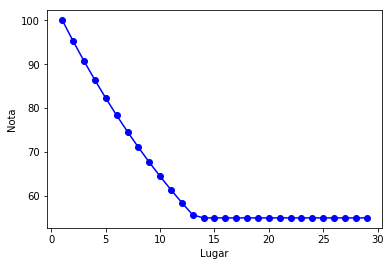

In [4]:
import numpy as np
t = np.arange(1,30)


def f(x):
    v =  100*((1.05**(1-x)))
    return v*(v>=55)+55*(v<55)

import matplotlib.pyplot as plt

plt.plot(t, f(t), 'bo-')
plt.xlabel("Lugar")
plt.ylabel("Nota")
plt.show()

In [6]:
for i in t:
    print("Posicion %d obtiene %f"%(i,f(i)))

Posicion 1 obtiene 100.000000
Posicion 2 obtiene 95.238095
Posicion 3 obtiene 90.702948
Posicion 4 obtiene 86.383760
Posicion 5 obtiene 82.270247
Posicion 6 obtiene 78.352617
Posicion 7 obtiene 74.621540
Posicion 8 obtiene 71.068133
Posicion 9 obtiene 67.683936
Posicion 10 obtiene 64.460892
Posicion 11 obtiene 61.391325
Posicion 12 obtiene 58.467929
Posicion 13 obtiene 55.683742
Posicion 14 obtiene 55.000000
Posicion 15 obtiene 55.000000
Posicion 16 obtiene 55.000000
Posicion 17 obtiene 55.000000
Posicion 18 obtiene 55.000000
Posicion 19 obtiene 55.000000
Posicion 20 obtiene 55.000000
Posicion 21 obtiene 55.000000
Posicion 22 obtiene 55.000000
Posicion 23 obtiene 55.000000
Posicion 24 obtiene 55.000000
Posicion 25 obtiene 55.000000
Posicion 26 obtiene 55.000000
Posicion 27 obtiene 55.000000
Posicion 28 obtiene 55.000000
Posicion 29 obtiene 55.000000


<a id="refs"></a>
## Referencias
[1] https://scikit-learn.org/stable/modules/ensemble.html  
[2] https://scikit-learn.org/stable/modules/tree.html  
[3] http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  
